In [9]:
import sys
import os
from pathlib import Path
try:
    import pyvips  # type: ignore
    _HAS_PYVIPS = True
except Exception:
    pyvips = None
    _HAS_PYVIPS = False

PROJECT_ROOT = Path("/home/users/ntu/lizh0106/scratch/nscc_work/Baseline_models")
os.chdir(PROJECT_ROOT)
#sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.config import load_paths, load_params
from src.data.features import prepare_features
from src.models.train import cross_validate, predict_external
from src.evaluation.grading import gleason_to_isup
from src.evaluation.metrics import evaluate_slide_predictions

# CONFIG

In [10]:
base_path =Path("results/hard_labels")

# ===================================
# test_folder = "XGB_nol2_with2048" # 需要和base_path链接，里面有aggc_prob_p 和tcga_prob_p

# df_aggc_index = "/home/users/ntu/lizh0106/scratch/nscc_work/Processed_Features/AGGC/20x_512/index.csv"
# df_tcga_index = "/home/users/ntu/lizh0106/scratch/nscc_work/Processed_Features/TGGA_PRAD_V2/TGGA_PRAD_V2_without_anno/TCGA_20x512/index.csv"

# aggc_prob_p = "aggc_oof_tile_proba.npy"
# tcga_prob_p = "tcga_proba_mean.npy"


In [11]:
# exps 是 base_path里所有文件夹名字
import json

from sklearn.metrics import classification_report
exps = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

metrics = ["acc_valid","balanced_acc_valid","classification_report"]

for experiments in exps:
    path_aggc = os.path.join(base_path, experiments, "metrics_aggc.json")
    path_tcga= os.path.join(base_path, experiments, "metrics_tcga.json")
    with open(path_aggc , 'r') as f:
        data_aggc = json.load(f)
    with open(path_tcga , 'r') as f:
        data_tcga= json.load(f)

print(type(data_tcga.get("classification_report")))
print(str(data_tcga.get("classification_report"))[:300])


<class 'str'>
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        98
           2       0.00      0.00      0.00        73
           3       0.06      0.06      0.06        34
           4       0.31      


In [12]:
import re
from typing import Any, Dict, Optional

def parse_classification_report_any(report: Any) -> Dict[str, Optional[float]]:
    """
    Accepts:
      - dict from sklearn (output_dict=True)
      - string text from sklearn default output
      - other wrapper dicts (try common keys)
    Returns:
      macro_f1, weighted_f1, macro_precision, macro_recall
    """
    out = {
        "macro_precision": None,
        "macro_recall": None,
        "macro_f1": None,
        "weighted_f1": None,
    }

    # 1) If it's a wrapper dict, try common keys first
    if isinstance(report, dict):
        # If it's already sklearn dict style
        if "macro avg" in report and isinstance(report["macro avg"], dict):
            macro = report.get("macro avg", {})
            weighted = report.get("weighted avg", {})
            out["macro_precision"] = float(macro.get("precision")) if macro.get("precision") is not None else None
            out["macro_recall"]    = float(macro.get("recall"))    if macro.get("recall")    is not None else None
            out["macro_f1"]        = float(macro.get("f1-score"))  if macro.get("f1-score")  is not None else None
            out["weighted_f1"]     = float(weighted.get("f1-score")) if weighted.get("f1-score") is not None else None
            return out

        # Otherwise maybe you stored text under a key
        for k in ["text", "report", "classification_report", "value"]:
            if k in report and isinstance(report[k], str):
                report = report[k]
                break

        # Or you stored dict under a key
        for k in ["dict", "output_dict", "cr_dict"]:
            if k in report and isinstance(report[k], dict):
                return parse_classification_report_any(report[k])

    # 2) If it's a string, parse macro avg / weighted avg rows
    if isinstance(report, str):
        # Normalize whitespace
        txt = report.replace("\t", " ")
        # match lines like:
        # macro avg      0.82      0.79      0.80       123
        # weighted avg   0.85      0.84      0.84       123
        def find_row(name: str):
            # capture 3 floats after name: precision recall f1
            pattern = rf"^{re.escape(name)}\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+([0-9]*\.?[0-9]+)\s+"
            for line in txt.splitlines():
                line = line.strip()
                m = re.match(pattern, line)
                if m:
                    return float(m.group(1)), float(m.group(2)), float(m.group(3))
            return None

        macro = find_row("macro avg")
        if macro is not None:
            out["macro_precision"], out["macro_recall"], out["macro_f1"] = macro

        weighted = find_row("weighted avg")
        if weighted is not None:
            _, _, out["weighted_f1"] = weighted

    return out


In [13]:
import os
import json
import math
from typing import Any, Dict, Tuple, Optional

import pandas as pd
import matplotlib.pyplot as plt


# ============ helpers ============

def _safe_get(d: Dict[str, Any], *keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

def _to_mean_std(x: Any) -> Tuple[Optional[float], Optional[float]]:
    """
    Accepts:
      - float/int -> (value, None)
      - list/tuple of numbers -> (mean, std)
      - dict with 'mean'/'std' or 'avg'/'std' -> (mean, std)
    """
    if x is None:
        return (None, None)

    if isinstance(x, (int, float)) and not isinstance(x, bool):
        return (float(x), None)

    if isinstance(x, (list, tuple)) and len(x) > 0:
        vals = [float(v) for v in x if v is not None and not (isinstance(v, float) and math.isnan(v))]
        if len(vals) == 0:
            return (None, None)
        mean = sum(vals) / len(vals)
        if len(vals) == 1:
            return (mean, 0.0)
        var = sum((v - mean) ** 2 for v in vals) / (len(vals) - 1)
        return (mean, math.sqrt(var))

    if isinstance(x, dict):
        for mk in ("mean", "avg", "average"):
            if mk in x:
                mean = x.get(mk)
                std = x.get("std") or x.get("stdev") or x.get("sd")
                return (float(mean) if mean is not None else None,
                        float(std) if std is not None else None)

    return (None, None)

def _extract_macro_metrics(class_report: Any) -> Dict[str, Optional[float]]:
    """
    sklearn classification_report as dict:
      report['macro avg']['precision'/'recall'/'f1-score']
      report['weighted avg'][...]
    """
    out = {
        "macro_precision": None,
        "macro_recall": None,
        "macro_f1": None,
        "weighted_f1": None,
    }
    if not isinstance(class_report, dict):
        return out

    macro = class_report.get("macro avg", {})
    weighted = class_report.get("weighted avg", {})

    def pick(d, k):
        v = d.get(k)
        if isinstance(v, (int, float)) and not isinstance(v, bool):
            return float(v)
        return None

    out["macro_precision"] = pick(macro, "precision")
    out["macro_recall"] = pick(macro, "recall")
    out["macro_f1"] = pick(macro, "f1-score")
    out["weighted_f1"] = pick(weighted, "f1-score")
    return out

def _load_json(path: str) -> Optional[Dict[str, Any]]:
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def _summarize_one(metrics: Dict[str, Any]) -> Dict[str, Any]:
    acc_m, acc_s = _to_mean_std(metrics.get("acc_valid"))
    bacc_m, bacc_s = _to_mean_std(metrics.get("balanced_acc_valid"))

    # robust parse for classification_report (dict or string)
    rep = metrics.get("classification_report")
    rep_metrics = parse_classification_report_any(rep)

    # If you explicitly stored macro_f1 somewhere, keep it; otherwise use parsed
    macro_f1_m, macro_f1_s = _to_mean_std(metrics.get("macro_f1"))
    if macro_f1_m is None:
        macro_f1_m = rep_metrics["macro_f1"]
        macro_f1_s = None

    return {
        "acc_mean": acc_m, "acc_std": acc_s,
        "bacc_mean": bacc_m, "bacc_std": bacc_s,
        "macro_f1_mean": macro_f1_m, "macro_f1_std": macro_f1_s,
        "macro_precision": rep_metrics["macro_precision"],
        "macro_recall": rep_metrics["macro_recall"],
        "weighted_f1": rep_metrics["weighted_f1"],
    }


def _fmt(mean: Optional[float], std: Optional[float], nd=3) -> str:
    if mean is None:
        return ""
    if std is None:
        return f"{mean:.{nd}f}"
    return f"{mean:.{nd}f} ± {std:.{nd}f}"


# ============ main: build table ============

# You already have base_path; keep using yours.
# base_path = "..."  # <-- make sure this exists

exps = [
    name for name in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, name))
]
exps.sort()

rows = []
for exp in exps:
    exp_dir = os.path.join(base_path, exp)
    path_aggc = os.path.join(exp_dir, "metrics_aggc.json")
    path_tcga = os.path.join(exp_dir, "metrics_tcga.json")

    for dataset_name, path in [("AGGC", path_aggc), ("TCGA", path_tcga)]:
        data = _load_json(path)
        if data is None:
            continue

        s = _summarize_one(data)
        row = {
            "experiment": exp,
            "dataset": dataset_name,
            "acc_mean": s["acc_mean"], "acc_std": s["acc_std"],
            "bacc_mean": s["bacc_mean"], "bacc_std": s["bacc_std"],
            "macro_f1_mean": s["macro_f1_mean"], "macro_f1_std": s["macro_f1_std"],
            "macro_precision": s["macro_precision"],
            "macro_recall": s["macro_recall"],
            "weighted_f1": s["weighted_f1"],
            "metrics_path": path,
        }
        rows.append(row)

df = pd.DataFrame(rows)

# Pretty columns for reporting
df["acc"] = df.apply(lambda r: _fmt(r["acc_mean"], r["acc_std"]), axis=1)
df["balanced_acc"] = df.apply(lambda r: _fmt(r["bacc_mean"], r["bacc_std"]), axis=1)
df["macro_f1"] = df.apply(lambda r: _fmt(r["macro_f1_mean"], r["macro_f1_std"]), axis=1)

# Keep the concise report view
report_df = df[[
    "experiment", "dataset",
    "acc", "balanced_acc", "macro_f1",
    "macro_precision", "macro_recall", "weighted_f1"
]].sort_values(["experiment", "dataset"])

print("\n=== Summary (copy into report) ===")
print(report_df.to_string(index=False))

# Save as CSVs
out_csv = os.path.join(base_path, "metrics_summary_long.csv")
out_csv_report = os.path.join(base_path, "metrics_summary_report_view.csv")
df.to_csv(out_csv, index=False)
report_df.to_csv(out_csv_report, index=False)
print(f"\nSaved:\n- {out_csv}\n- {out_csv_report}")


# ============ simple visualization ============

def plot_metric(
    df_long: pd.DataFrame,
    metric_col: str,
    title: str,
    out_png: str = None,
    save: bool = False
):
    """
    Bar chart: AGGC vs TCGA (same experiment ordering).

    Parameters
    ----------
    df_long : long-format dataframe
    metric_col : column name to plot (e.g. 'bacc_mean')
    title : plot title
    out_png : path to save (optional)
    save : whether to save figure (default False)
    """

    fig, ax = plt.subplots(figsize=(12, 5))

    pivot = df_long.pivot_table(
        index="experiment",
        columns="dataset",
        values=metric_col,
        aggfunc="first"
    ).sort_index()

    cols = [c for c in ["AGGC", "TCGA"] if c in pivot.columns]
    pivot = pivot[cols]

    pivot.plot(kind="bar", ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Experiment")
    ax.set_ylabel(metric_col)

    ax.tick_params(axis="x", rotation=45)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment("right")

    ax.legend(title="Dataset")
    fig.tight_layout()

    if save:
        if out_png is None:
            raise ValueError("save=True but out_png is None")
        fig.savefig(out_png, dpi=200)
        print(f"Saved plot: {out_png}")
        plt.close(fig)
    else:
        plt.show()




# # Optional: rank experiments by TCGA balanced accuracy (or AGGC)
# rank = (
#     df[df["dataset"] == "TCGA"][["experiment", "bacc_mean", "macro_f1_mean", "acc_mean"]]
#     .sort_values("bacc_mean", ascending=False)
# )
# print("\n=== Rank by TCGA balanced accuracy ===")
# print(rank.to_string(index=False))



=== Summary (copy into report) ===
          experiment dataset   acc balanced_acc macro_f1  macro_precision  macro_recall  weighted_f1
  LR_SGD_l2_tileonly    AGGC 0.439        0.340    0.330             0.35          0.34         0.46
  LR_SGD_l2_tileonly    TCGA 0.476        0.404    0.410             0.46          0.40         0.48
  LR_SGD_l2_with2048    AGGC 0.492        0.361    0.340             0.35          0.36         0.49
  LR_SGD_l2_with2048    TCGA 0.463        0.432    0.420             0.43          0.43         0.47
LR_SGD_nol2_tileonly    AGGC 0.374        0.291    0.280             0.33          0.29         0.40
LR_SGD_nol2_tileonly    TCGA 0.278        0.212    0.110             0.07          0.21         0.13
LR_SGD_nol2_with2048    AGGC 0.406        0.306    0.280             0.27          0.31         0.40
LR_SGD_nol2_with2048    TCGA 0.241        0.202    0.120             0.18          0.20         0.15
     MLP_l2_tileonly    AGGC 0.620        0.365    0.36

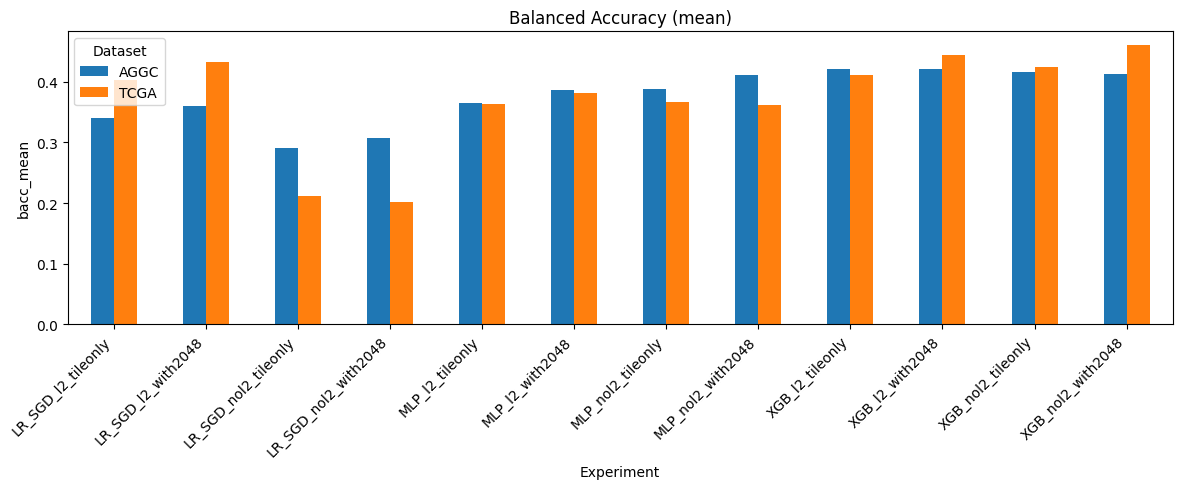

In [14]:
plot_metric(
    df,
    "bacc_mean",
    "Balanced Accuracy (mean)",
    out_png=os.path.join(base_path, "plot_balanced_acc.png"),
    save=False
)

/tmp/ipykernel_2401347/3974670152.py:120: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = sdf.pivot_table(index="method", columns="dataset", values="bacc_mean", aggfunc="mean")


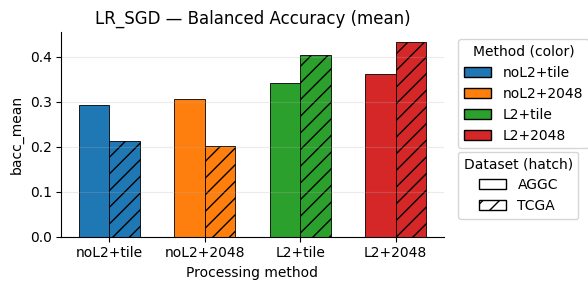

/tmp/ipykernel_2401347/3974670152.py:120: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = sdf.pivot_table(index="method", columns="dataset", values="bacc_mean", aggfunc="mean")


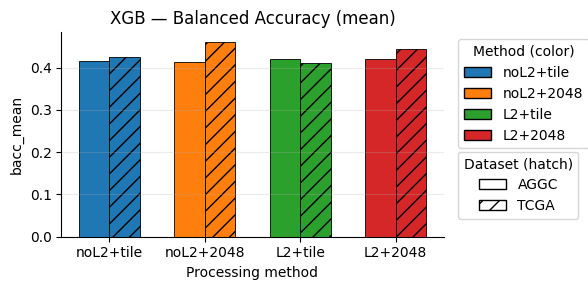

/tmp/ipykernel_2401347/3974670152.py:120: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = sdf.pivot_table(index="method", columns="dataset", values="bacc_mean", aggfunc="mean")


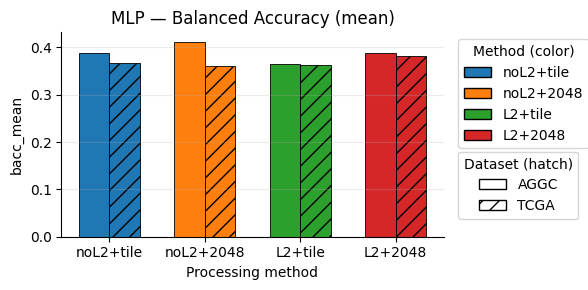

In [23]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# -----------------------------
# 1) parse experiment name
# -----------------------------
KNOWN_MODELS = ["LR_SGD", "XGB", "MLP"]

def parse_experiment_name(exp: str):
    """
    Example names:
      LR_SGD_nol2_with2048
      LR_SGD_l2_tileonly
      XGB_l2_with2048
      MLP_nol2_tileonly
    Returns: model, l2 (0/1), combine_2048 (0/1)
    """
    model = None
    for m in KNOWN_MODELS:
        if exp.startswith(m + "_") or exp == m:
            model = m
            rest = exp[len(m):].lstrip("_")
            break

    if model is None:
        # fallback: take first token
        toks = exp.split("_")
        model = toks[0]
        rest = "_".join(toks[1:]) if len(toks) > 1 else ""

    rest_tokens = [t for t in rest.split("_") if t]

    l2 = None
    if "l2" in rest_tokens:
        l2 = 1
    if "nol2" in rest_tokens:
        l2 = 0
    if l2 is None:
        # default if missing
        l2 = 1

    combine_2048 = None
    if "with2048" in rest_tokens:
        combine_2048 = 1
    if "tileonly" in rest_tokens:
        combine_2048 = 0
    if combine_2048 is None:
        # default if missing
        combine_2048 = 0

    return model, l2, combine_2048


def add_config_columns(df_long: pd.DataFrame) -> pd.DataFrame:
    df2 = df_long.copy()
    parsed = df2["experiment"].apply(parse_experiment_name)
    df2["model"] = parsed.apply(lambda x: x[0])
    df2["l2"] = parsed.apply(lambda x: x[1])
    df2["combine_2048"] = parsed.apply(lambda x: x[2])

    # method label (4 groups)
    def method_label(r):
        l2_txt = "L2" if r["l2"] == 1 else "noL2"
        feat_txt = "2048" if r["combine_2048"] == 1 else "tile"
        return f"{l2_txt}+{feat_txt}"

    df2["method"] = df2.apply(method_label, axis=1)
    return df2


# -----------------------------
# 2) build a tidy summary df
# -----------------------------
# df is your long df from earlier (rows: experiment x dataset)
df2 = add_config_columns(df)

# keep only rows where bacc exists
df2 = df2.dropna(subset=["bacc_mean"])

# If each (experiment,dataset) is unique, this groupby is basically a passthrough.
# Still useful in case you later have repeats (e.g., multiple runs dumped together).
summary = (
    df2.groupby(["model", "method", "dataset"], as_index=False)
       .agg(bacc_mean=("bacc_mean", "mean"))
)

# optional: ensure dataset order
dataset_order = ["AGGC", "TCGA"]
summary["dataset"] = pd.Categorical(summary["dataset"], categories=dataset_order, ordered=True)
summary = summary.sort_values(["model", "method", "dataset"])


# -----------------------------
# 3) plotting: one small figure per model
# -----------------------------
METHOD_ORDER = ["noL2+tile", "noL2+2048", "L2+tile", "L2+2048"]

# 4 colors for 4 methods (you explicitly asked for this)
METHOD_COLORS = {
    "noL2+tile":  "#1f77b4",
    "noL2+2048":  "#ff7f0e",
    "L2+tile":    "#2ca02c",
    "L2+2048":    "#d62728",
}

HATCH = {"AGGC": "", "TCGA": "//"}  # same color per method, hatch distinguishes dataset


def plot_bacc_per_model(summary_df: pd.DataFrame, model: str, save: bool = False, out_png: str = None):
    sdf = summary_df[summary_df["model"] == model].copy()
    if sdf.empty:
        print(f"[skip] No data for model={model}")
        return

    # pivot to get values quickly: rows=method, cols=dataset
    pv = sdf.pivot_table(index="method", columns="dataset", values="bacc_mean", aggfunc="mean")

    # enforce method order
    pv = pv.reindex(METHOD_ORDER)

    # x positions: 4 methods
    x = np.arange(len(METHOD_ORDER))
    width = 0.32  # bars for AGGC and TCGA within a method

    fig, ax = plt.subplots(figsize=(6, 3))

    # for each method draw AGGC + TCGA bars with same color, different hatch
    for i, method in enumerate(METHOD_ORDER):
        color = METHOD_COLORS.get(method, None)

        for j, ds in enumerate(dataset_order):
            if ds not in pv.columns:
                continue
            val = pv.loc[method, ds] if method in pv.index else np.nan
            if pd.isna(val):
                continue

            # offset within each method group
            offset = (-width / 2) if ds == "AGGC" else (width / 2)
            ax.bar(
                x[i] + offset,
                val,
                width=width,
                color=color,
                hatch=HATCH[ds],
                edgecolor="black",
                linewidth=0.6,
            )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f"{model} — Balanced Accuracy (mean)")
    ax.set_xlabel("Processing method")
    ax.set_ylabel("bacc_mean")
    ax.set_xticks(x)
    ax.set_xticklabels(METHOD_ORDER, rotation=0)

    # Legends: one for methods (colors), one for datasets (hatches)
    method_handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", label=m) for m in METHOD_ORDER]
    dataset_handles = [
        Patch(facecolor="white", edgecolor="black", hatch=HATCH["AGGC"], label="AGGC"),
        Patch(facecolor="white", edgecolor="black", hatch=HATCH["TCGA"], label="TCGA"),
    ]
    leg1 = ax.legend(handles=method_handles, title="Method (color)", loc="upper left", bbox_to_anchor=(1.02, 1.0))
    ax.add_artist(leg1)
    ax.legend(handles=dataset_handles, title="Dataset (hatch)", loc="upper left", bbox_to_anchor=(1.02, 0.45))

    ax.grid(axis="y", alpha=0.25)
    fig.tight_layout()

    if save:
        if out_png is None:
            raise ValueError("save=True but out_png is None")
        fig.savefig(out_png, dpi=200)
        plt.close(fig)
        print(f"Saved plot: {out_png}")
    else:
        plt.show()

SAVE_IMG = False
# -----------------------------
# 4) call: three models, three small plots
# -----------------------------
for m in ["LR_SGD", "XGB", "MLP"]:
    if SAVE_IMG:

        plot_bacc_per_model(summary, m, save=True, out_png=f"results/viz/bacc_{m}.png")
    else:
        plot_bacc_per_model(summary, m, save=False)

In [22]:
out_csv_2 = os.path.join(base_path, "metrics_parsed.csv")
df.to_csv(out_csv_2, index=False)